In [0]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
random.seed(42)

In this project we are analyzing data from whodo. The documentation and further explanation of the company is below.
https://drive.google.com/file/d/1eFYH4Yagh22sU4TdNuDnr-Ne3VROISGw/view?usp=sharing


# Data Parsing

## Import Data

In [45]:
df = pd.read_csv("https://riipen-platform-ca-central-1-production.s3.ca-central-1.amazonaws.com/files/e0232977-f03d-4843-aaeb-a8ae23f5d08d.csv")
pd.set_option('display.max_rows', df.shape[0]+1)
df = df.rename(columns={'facet.1': 'facet1', 'reverse\n':'reverse1'})
df.dropna(subset = ['item'], inplace = True)
df.head(5)

,item,topic01,topic02,topic03,topic04,primary_factor,facet,reverse,secondary_factor,facet1,reverse1,type1,type2,type3,WX,WX.1,NX,WY,WX.2,WX.3,WY.1,NY,WX.4,NX.1,WY.2,WY.3,NY.1,WX.5,NX.2,WY.4,WX.6,WY.5,NX.3,WX.7,WY.6,WY.7,WX.8,NY.2,WX.9,WY.8,WX.10,NY.3,WY.9,WX.11,NX.4,WX.12,WY.10,WX.13,WY.11,WX.14,NX.5,WY.12,WY.13,WX.15,NY.4,WX.16,WY.14,NX.6,WX.17,WY.15,WX.18,NY.5,NX.7,NY.6
0,"Saying ""thank you"" when someone holds the door.",In Public,Service,NaN,NaN,Extraversion,Positive Emotions,True,Agreeableness,Compliance,True,NaN,NaN,NaN,1.0,1.0,0.5,0.5,1.0,1.0,0.5,0.0,1.0,0.5,0.5,0.5,0.0,1.0,0.5,0.5,1.0,0.5,0.5,1.0,0.5,0.5,1.0,0.0,1.0,0.5,1.0,0.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,0.5,0.5,1.0,0.0,1.0,0.5,0.5,1.0,0.5,1.0,0.0,0.5,0.0
1,"Low talking, or talking at a volume that's har...",Personal,Friends,Habits,NaN,Natural_Reactions,Self-Consciousness,True,Extraversion,Assertiveness,False,NaN,NaN,NaN,0.0,0.0,0.0,-0.5,0.0,-0.5,-0.5,-0.5,0.0,0.0,-0.5,-0.5,-0.5,0.0,0.0,-0.5,0.0,-0.5,0.0,0.0,-0.5,-0.5,0.0,-0.5,0.0,-0.5,0.0,-0.5,-0.5,0.0,0.0,0.0,-0.5,0.0,-0.5,0.0,0.0,-0.5,-0.5,0.0,-0.5,0.0,-0.5,0.0,0.0,-0.5,0.0,-0.5,0.0,-0.5
2,Standing close to a stranger in public.,In Public,NaN,NaN,NaN,Extraversion,Gregariousness,True,Agreeableness,Modesty,False,NaN,NaN,NaN,1.0,1.0,0.5,0.5,1.0,0.0,0.5,0.0,1.0,0.5,0.5,0.5,0.0,1.0,0.5,0.5,1.0,0.5,0.5,1.0,0.5,0.5,1.0,0.0,1.0,0.5,1.0,0.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,0.5,0.5,1.0,0.0,1.0,0.5,0.5,1.0,0.5,1.0,0.0,0.5,0.0
3,Making out with someone in an elevator with ot...,Love & Sex,In Public,NaN,NaN,Openness,Willingness to Experiment,True,Extraversion,Excitement-Seeking,True,Relationship,NaN,NaN,0.0,0.0,-0.5,0.5,0.0,-1.0,0.5,0.0,0.0,-0.5,0.5,0.5,0.0,0.0,-0.5,0.5,0.0,0.5,-0.5,0.0,0.5,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,-0.5,0.0,0.5,0.0,0.5,0.0,-0.5,0.5,0.5,0.0,0.0,0.0,0.5,-0.5,0.0,0.5,0.0,0.0,-0.5,0.0
4,Having a loud conversation on the elevator.,In Public,Work,NaN,NaN,Extraversion,Activity Level,True,Natural_Reactions,Self-Consciousness,False,NaN,NaN,NaN,0.5,-0.5,0.0,1.0,0.5,-0.5,1.0,0.5,0.5,0.0,1.0,1.0,0.5,0.5,0.0,1.0,0.5,1.0,0.0,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,1.0,0.5,0.0,0.5,1.0,0.5,1.0,0.5,0.0,1.0,1.0,0.5,0.5,0.5,1.0,0.0,0.5,1.0,0.5,0.5,0.0,0.5


In [46]:
df.iloc[:,15:30].head(5)

,WX.1,NX,WY,WX.2,WX.3,WY.1,NY,WX.4,NX.1,WY.2,WY.3,NY.1,WX.5,NX.2,WY.4
0,1.0,0.5,0.5,1.0,1.0,0.5,0.0,1.0,0.5,0.5,0.5,0.0,1.0,0.5,0.5
1,0.0,0.0,-0.5,0.0,-0.5,-0.5,-0.5,0.0,0.0,-0.5,-0.5,-0.5,0.0,0.0,-0.5
2,1.0,0.5,0.5,1.0,0.0,0.5,0.0,1.0,0.5,0.5,0.5,0.0,1.0,0.5,0.5
3,0.0,-0.5,0.5,0.0,-1.0,0.5,0.0,0.0,-0.5,0.5,0.5,0.0,0.0,-0.5,0.5
4,-0.5,0.0,1.0,0.5,-0.5,1.0,0.5,0.5,0.0,1.0,1.0,0.5,0.5,0.0,1.0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 64 columns):
item                100 non-null object
topic01             100 non-null object
topic02             60 non-null object
topic03             15 non-null object
topic04             1 non-null object
primary_factor      100 non-null object
facet               100 non-null object
reverse             100 non-null bool
secondary_factor    100 non-null object
facet1              100 non-null object
reverse1            100 non-null bool
type1               52 non-null object
type2               8 non-null object
type3               2 non-null object
WX                  100 non-null float64
WX.1                100 non-null float64
NX                  100 non-null float64
WY                  100 non-null float64
WX.2                100 non-null float64
WX.3                100 non-null float64
WY.1                100 non-null float64
NY                  100 non-null float64
WX.4                1

## Data Wrangling

In [48]:
print(list(df.columns))

['item', 'topic01', 'topic02', 'topic03', 'topic04', 'primary_factor', 'facet', 'reverse', 'secondary_factor', 'facet1', 'reverse1', 'type1', 'type2', 'type3', 'WX', 'WX.1', 'NX', 'WY', 'WX.2', 'WX.3', 'WY.1', 'NY', 'WX.4', 'NX.1', 'WY.2', 'WY.3', 'NY.1', 'WX.5', 'NX.2', 'WY.4', 'WX.6', 'WY.5', 'NX.3', 'WX.7', 'WY.6', 'WY.7', 'WX.8', 'NY.2', 'WX.9', 'WY.8', 'WX.10', 'NY.3', 'WY.9', 'WX.11', 'NX.4', 'WX.12', 'WY.10', 'WX.13', 'WY.11', 'WX.14', 'NX.5', 'WY.12', 'WY.13', 'WX.15', 'NY.4', 'WX.16', 'WY.14', 'NX.6', 'WX.17', 'WY.15', 'WX.18', 'NY.5', 'NX.7', 'NY.6']


### Address Secondary Factor

In [49]:
#Cols for datasets
col1 = ['item', 'topic01', 'topic02', 'topic03', 'topic04', 'primary_factor', 'facet', 'reverse', 
            'type1', 'type2', 'type3', 'WX', 'WX.1', 'NX', 'WY', 'WX.2', 'WX.3', 'WY.1', 
            'NY', 'WX.4', 'NX.1', 'WY.2', 'WY.3', 'NY.1', 'WX.5', 'NX.2', 'WY.4', 'WX.6', 'WY.5', 
            'NX.3', 'WX.7', 'WY.6', 'WY.7', 'WX.8', 'NY.2', 'WX.9', 'WY.8', 'WX.10', 'NY.3', 'WY.9', 
            'WX.11', 'NX.4', 'WX.12', 'WY.10', 'WX.13', 'WY.11', 'WX.14', 'NX.5', 'WY.12', 'WY.13', 
            'WX.15', 'NY.4', 'WX.16', 'WY.14', 'NX.6', 'WX.17', 'WY.15', 'WX.18', 'NY.5', 'NX.7', 'NY.6']

col2 = ['item', 'topic01', 'topic02', 'topic03', 'topic04', 'secondary_factor', 'facet1', 'reverse1',
            'type1', 'type2', 'type3', 'WX', 'WX.1', 'NX', 'WY', 'WX.2', 'WX.3', 'WY.1', 
            'NY', 'WX.4', 'NX.1', 'WY.2', 'WY.3', 'NY.1', 'WX.5', 'NX.2', 'WY.4', 'WX.6', 'WY.5', 
            'NX.3', 'WX.7', 'WY.6', 'WY.7', 'WX.8', 'NY.2', 'WX.9', 'WY.8', 'WX.10', 'NY.3', 'WY.9', 
            'WX.11', 'NX.4', 'WX.12', 'WY.10', 'WX.13', 'WY.11', 'WX.14', 'NX.5', 'WY.12', 'WY.13', 
            'WX.15', 'NY.4', 'WX.16', 'WY.14', 'NX.6', 'WX.17', 'WY.15', 'WX.18', 'NY.5', 'NX.7', 'NY.6']

# Create data1 for col1
df1 = df[col1]

# Create data2 for col2
df2 = df[col2]

#Change colum names of df2 to match df1
df2.columns = col1

#Append data
data = df1.append(df2, ignore_index=True)

# delete dataframes from memory
del df1, df2

#Change data type of 'reverse' to string
data['reverse'] = data['reverse'].astype(str)
#dataML = data

#See dataframe
data.head(5)

,item,topic01,topic02,topic03,topic04,primary_factor,facet,reverse,type1,type2,type3,WX,WX.1,NX,WY,WX.2,WX.3,WY.1,NY,WX.4,NX.1,WY.2,WY.3,NY.1,WX.5,NX.2,WY.4,WX.6,WY.5,NX.3,WX.7,WY.6,WY.7,WX.8,NY.2,WX.9,WY.8,WX.10,NY.3,WY.9,WX.11,NX.4,WX.12,WY.10,WX.13,WY.11,WX.14,NX.5,WY.12,WY.13,WX.15,NY.4,WX.16,WY.14,NX.6,WX.17,WY.15,WX.18,NY.5,NX.7,NY.6
0,"Saying ""thank you"" when someone holds the door.",In Public,Service,NaN,NaN,Extraversion,Positive Emotions,True,NaN,NaN,NaN,1.0,1.0,0.5,0.5,1.0,1.0,0.5,0.0,1.0,0.5,0.5,0.5,0.0,1.0,0.5,0.5,1.0,0.5,0.5,1.0,0.5,0.5,1.0,0.0,1.0,0.5,1.0,0.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,0.5,0.5,1.0,0.0,1.0,0.5,0.5,1.0,0.5,1.0,0.0,0.5,0.0
1,"Low talking, or talking at a volume that's har...",Personal,Friends,Habits,NaN,Natural_Reactions,Self-Consciousness,True,NaN,NaN,NaN,0.0,0.0,0.0,-0.5,0.0,-0.5,-0.5,-0.5,0.0,0.0,-0.5,-0.5,-0.5,0.0,0.0,-0.5,0.0,-0.5,0.0,0.0,-0.5,-0.5,0.0,-0.5,0.0,-0.5,0.0,-0.5,-0.5,0.0,0.0,0.0,-0.5,0.0,-0.5,0.0,0.0,-0.5,-0.5,0.0,-0.5,0.0,-0.5,0.0,0.0,-0.5,0.0,-0.5,0.0,-0.5
2,Standing close to a stranger in public.,In Public,NaN,NaN,NaN,Extraversion,Gregariousness,True,NaN,NaN,NaN,1.0,1.0,0.5,0.5,1.0,0.0,0.5,0.0,1.0,0.5,0.5,0.5,0.0,1.0,0.5,0.5,1.0,0.5,0.5,1.0,0.5,0.5,1.0,0.0,1.0,0.5,1.0,0.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,0.5,0.5,1.0,0.0,1.0,0.5,0.5,1.0,0.5,1.0,0.0,0.5,0.0
3,Making out with someone in an elevator with ot...,Love & Sex,In Public,NaN,NaN,Openness,Willingness to Experiment,True,Relationship,NaN,NaN,0.0,0.0,-0.5,0.5,0.0,-1.0,0.5,0.0,0.0,-0.5,0.5,0.5,0.0,0.0,-0.5,0.5,0.0,0.5,-0.5,0.0,0.5,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,-0.5,0.0,0.5,0.0,0.5,0.0,-0.5,0.5,0.5,0.0,0.0,0.0,0.5,-0.5,0.0,0.5,0.0,0.0,-0.5,0.0
4,Having a loud conversation on the elevator.,In Public,Work,NaN,NaN,Extraversion,Activity Level,True,NaN,NaN,NaN,0.5,-0.5,0.0,1.0,0.5,-0.5,1.0,0.5,0.5,0.0,1.0,1.0,0.5,0.5,0.0,1.0,0.5,1.0,0.0,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,1.0,0.5,0.0,0.5,1.0,0.5,1.0,0.5,0.0,1.0,1.0,0.5,0.5,0.5,1.0,0.0,0.5,1.0,0.5,0.5,0.0,0.5


### Address Reverse Field

In [50]:
data.iloc[:,11:].columns

Index(['WX', 'WX.1', 'NX', 'WY', 'WX.2', 'WX.3', 'WY.1', 'NY', 'WX.4', 'NX.1',
       'WY.2', 'WY.3', 'NY.1', 'WX.5', 'NX.2', 'WY.4', 'WX.6', 'WY.5', 'NX.3',
       'WX.7', 'WY.6', 'WY.7', 'WX.8', 'NY.2', 'WX.9', 'WY.8', 'WX.10', 'NY.3',
       'WY.9', 'WX.11', 'NX.4', 'WX.12', 'WY.10', 'WX.13', 'WY.11', 'WX.14',
       'NX.5', 'WY.12', 'WY.13', 'WX.15', 'NY.4', 'WX.16', 'WY.14', 'NX.6',
       'WX.17', 'WY.15', 'WX.18', 'NY.5', 'NX.7', 'NY.6'],
      dtype='object')

In [51]:
col = data.iloc[:,11:].columns

# Split data to only include reverse = true values
data1 = data[data.reverse == 'True']

# Split data to only include reverse = false values
data2 = data[data.reverse == 'False']
#print(dataF.head(1))

# For reverse = false, multiply the col with -1
data3 = data2[col]*-1
data2[col] = data3[col]
#print(dataF.head(1))

dataa = pd.DataFrame()

#Append True and False dataframe
dataa = data1.append(data2, ignore_index=True)

# delete dataframes from memory
del data1, data2, data3

#See dataframe
dataa.head(1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,item,topic01,topic02,topic03,topic04,primary_factor,facet,reverse,type1,type2,type3,WX,WX.1,NX,WY,WX.2,WX.3,WY.1,NY,WX.4,NX.1,WY.2,WY.3,NY.1,WX.5,NX.2,WY.4,WX.6,WY.5,NX.3,WX.7,WY.6,WY.7,WX.8,NY.2,WX.9,WY.8,WX.10,NY.3,WY.9,WX.11,NX.4,WX.12,WY.10,WX.13,WY.11,WX.14,NX.5,WY.12,WY.13,WX.15,NY.4,WX.16,WY.14,NX.6,WX.17,WY.15,WX.18,NY.5,NX.7,NY.6
0,"Saying ""thank you"" when someone holds the door.",In Public,Service,NaN,NaN,Extraversion,Positive Emotions,True,NaN,NaN,NaN,1.0,1.0,0.5,0.5,1.0,1.0,0.5,0.0,1.0,0.5,0.5,0.5,0.0,1.0,0.5,0.5,1.0,0.5,0.5,1.0,0.5,0.5,1.0,0.0,1.0,0.5,1.0,0.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,0.5,0.5,1.0,0.0,1.0,0.5,0.5,1.0,0.5,1.0,0.0,0.5,0.0



### Reshape Data



In [52]:
l1 = dataa.iloc[:,11:].columns
l2 = dataa.iloc[:,:11].columns

reshapedata = pd.DataFrame()
joined_list = []

for col in l1:
    tempdata = pd.DataFrame()
    joined_list = [*l2, str(col)]
    tempdata = dataa[joined_list]
    tempdata['response'] = tempdata[col].apply(lambda x: str(x) + str('/') + str(col)[:2])
    tempdata.drop(columns = col, inplace = True)
    reshapedata = reshapedata.append(tempdata, ignore_index=True)

# new data frame with split value columns 
new = reshapedata["response"].str.split("/", n = 1, expand = True) 
#assign values to reshapedata
reshapedata["response"]= new[0]
reshapedata["category"]= new[1]
#change Response to double
reshapedata["response"] = pd.to_numeric(reshapedata["response"])
#split category
reshapedata['Race'] = reshapedata["category"].apply(lambda x: x[0])
reshapedata['Sex'] = reshapedata["category"].apply(lambda x: x[1])
#drop columns that are not required
reshapedata.drop(columns = ['item','category'], inplace = True)

reshapedata.info()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
topic01           10000 non-null object
topic02           6000 non-null object
topic03           1500 non-null object
topic04           100 non-null object
primary_factor    10000 non-null object
facet             10000 non-null object
reverse           10000 non-null object
type1             5200 non-null object
type2             800 non-null object
type3             200 non-null object
response          10000 non-null float64
Race              10000 non-null object
Sex               10000 non-null object
dtypes: float64(1), object(12)
memory usage: 1015.8+ KB


In [53]:
reshapedata.head()

,topic01,topic02,topic03,topic04,primary_factor,facet,reverse,type1,type2,type3,response,Race,Sex
0,In Public,Service,NaN,NaN,Extraversion,Positive Emotions,True,NaN,NaN,NaN,1.0,W,X
1,Personal,Friends,Habits,NaN,Natural_Reactions,Self-Consciousness,True,NaN,NaN,NaN,0.0,W,X
2,In Public,NaN,NaN,NaN,Extraversion,Gregariousness,True,NaN,NaN,NaN,1.0,W,X
3,Love & Sex,In Public,NaN,NaN,Openness,Willingness to Experiment,True,Relationship,NaN,NaN,0.0,W,X
4,In Public,Work,NaN,NaN,Extraversion,Activity Level,True,NaN,NaN,NaN,0.5,W,X


### Address User Responses

dataa1 = dataa
dataa1['wxavg'] = dataa.filter(regex='WX').mean(axis = 1)
dataa1['nxavg'] = dataa.filter(regex='NX').mean(axis = 1)
dataa1['wyavg'] = dataa.filter(regex='WY').mean(axis = 1)
dataa1['nyavg'] = dataa.filter(regex='NY').mean(axis = 1)
dataa1 = dataa.drop(columns = col)
dataa1 = dataa.drop(s = ['item','reverse'])

dataa1.head()

### Address Multiple Topics


In [54]:
colt1 = ['topic01',
         'primary_factor', 'facet', 'type1', 'type2', 'type3', 'response', 'Race', 'Sex']

colt2 =  ['topic02', 
         'primary_factor', 'facet', 'type1', 'type2', 'type3','response', 'Race', 'Sex']

colt3 =  ['topic03',
         'primary_factor', 'facet', 'type1', 'type2', 'type3','response', 'Race', 'Sex']

colt4 =  ['topic04', 
         'primary_factor', 'facet', 'type1', 'type2', 'type3','response', 'Race', 'Sex']

dataa = reshapedata

# Create topic1
data1 = dataa[colt1]

# Create topic2
data2 = dataa[colt2]

# Create topic3
data3 = dataa[colt3]

# Create topic4
data4 = dataa[colt4]

#Change colum names to match data1
data2.columns = colt1
data3.columns = colt1
data4.columns = colt1

dataa = pd.DataFrame()

#Append data
dataa = data1.append(data2, ignore_index=True)
dataa = dataa.append(data3, ignore_index=True)
dataa = dataa.append(data4, ignore_index=True)

#dropna values from topic01
dataa = dataa.dropna(subset=['topic01'])
dataa = dataa.reset_index(drop=True)

# delete dataframes from memory
del data1, data2, data3, data4

#Final data
dataa.head()

,topic01,primary_factor,facet,type1,type2,type3,response,Race,Sex
0,In Public,Extraversion,Positive Emotions,NaN,NaN,NaN,1.0,W,X
1,Personal,Natural_Reactions,Self-Consciousness,NaN,NaN,NaN,0.0,W,X
2,In Public,Extraversion,Gregariousness,NaN,NaN,NaN,1.0,W,X
3,Love & Sex,Openness,Willingness to Experiment,Relationship,NaN,NaN,0.0,W,X
4,In Public,Extraversion,Activity Level,NaN,NaN,NaN,0.5,W,X


In [55]:
dataa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17600 entries, 0 to 17599
Data columns (total 9 columns):
topic01           17600 non-null object
primary_factor    17600 non-null object
facet             17600 non-null object
type1             9900 non-null object
type2             1900 non-null object
type3             700 non-null object
response          17600 non-null float64
Race              17600 non-null object
Sex               17600 non-null object
dtypes: float64(1), object(8)
memory usage: 1.2+ MB


### Address Multiple Types

In [56]:
colt1 = ['topic01', 'primary_factor', 'facet', 
         'type1', 
         'response', 'Race', 'Sex']
colt2 = ['topic01', 'primary_factor', 'facet', 
         'type2',
         'response', 'Race', 'Sex']
colt3 = ['topic01', 'primary_factor', 'facet', 
         'type3', 
         'response', 'Race', 'Sex']

# Create type1
data1 = dataa[colt1]

# Create type2
data2 = dataa[colt2]

# Create type3
data3 = dataa[colt3]

#Change colum names to match data1
data2.columns = colt1
data3.columns = colt1

dataa = pd.DataFrame()

#Append data
dataa = data1.append(data2, ignore_index=True)
dataa = dataa.append(data3, ignore_index=True)

#dropna values from topic01
#data = data.dropna(subset=['type1'])
dataa = dataa.reset_index(drop=True)

# delete dataframes from memory
del data1, data2, data3

#Final data
dataa.head()

,topic01,primary_factor,facet,type1,response,Race,Sex
0,In Public,Extraversion,Positive Emotions,NaN,1.0,W,X
1,Personal,Natural_Reactions,Self-Consciousness,NaN,0.0,W,X
2,In Public,Extraversion,Gregariousness,NaN,1.0,W,X
3,Love & Sex,Openness,Willingness to Experiment,Relationship,0.0,W,X
4,In Public,Extraversion,Activity Level,NaN,0.5,W,X


In [57]:
dataa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52800 entries, 0 to 52799
Data columns (total 7 columns):
topic01           52800 non-null object
primary_factor    52800 non-null object
facet             52800 non-null object
type1             12500 non-null object
response          52800 non-null float64
Race              52800 non-null object
Sex               52800 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ MB


## Final Data for Machine Learning

In [0]:
dataa.to_csv('data.csv',index=False)

### Final Data for Exploration

In [59]:
dataa = dataa.rename(columns={'topic01': 'topic', 'type1': 'type', 'primary_factor':'factor'})
dataa = dataa.replace(r'', np.NaN)
dataa = dataa.reset_index(drop=True)
dataa.info()
dataa.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52800 entries, 0 to 52799
Data columns (total 7 columns):
topic       52800 non-null object
factor      52800 non-null object
facet       52800 non-null object
type        12500 non-null object
response    52800 non-null float64
Race        52800 non-null object
Sex         52800 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ MB


,topic,factor,facet,type,response,Race,Sex
0,In Public,Extraversion,Positive Emotions,NaN,1.0,W,X
1,Personal,Natural_Reactions,Self-Consciousness,NaN,0.0,W,X
2,In Public,Extraversion,Gregariousness,NaN,1.0,W,X
3,Love & Sex,Openness,Willingness to Experiment,Relationship,0.0,W,X
4,In Public,Extraversion,Activity Level,NaN,0.5,W,X


# Data Exploration

In [60]:
dataa.groupby('topic').agg([np.mean])

,response
,mean
topic,
Food & Drink,0.013333
Friends,0.086818
Habits,0.096000
Home & Family,0.151111
In Public,0.047586
Internet Etc,0.018571
Love & Sex,0.029091
Money,0.062000


In [61]:
dataa.groupby(['factor','facet']).agg([np.mean])

response
                                                 mean
factor            facet                              
Agreeableness     Altruism                  -0.130000
                  Compliance                 0.050000
                  Modesty                    0.012308
                  Sincerity                  0.088000
                  Sympathy                   0.028333
                  Trust in others            0.190833
Conscientiousness Achievement Striving       0.387500
                  Cautiousness               0.105000
                  Orderliness                0.060000
                  Self-Discipline            0.341000
                  Sense of Competence        0.410000
                  Sense of Responsibility    0.316000
Extraversion      Activity Level             0.173333
                  Assertiveness              0.211167
                  Excitement-Seeking         0.224615
                  Gregariousness             0.395000
                  Positive Emotions          0.610000
                  Warmth                    -0.001429
Natural_Reactions Anxiety                   -0.444444
                  Expressing Hostility      -0.360000
                  Moodiness                 -0.056364
                  Self-Consciousness        -0.136176
                  Self-Indulgence           -0.100000
                  Sensitivity to Stress     -0.162857
Openness          Artistic Interests         0.118750
                  Depth of Emotions          0.124000
                  Imagination                0.111429
                  Intellectual Curiosity     0.006923
                  Tolerance for Diversity    0.222857
                  Willingness to Experiment  0.009615

In [62]:
dataa.groupby('type').agg([np.mean])

,response
,mean
type,
Age,0.000000
Ethical,0.023333
Funny,0.000000
Gendered,0.000000
Gross,0.422500
Parental,0.132000
Relationship,0.082619
School,0.540000


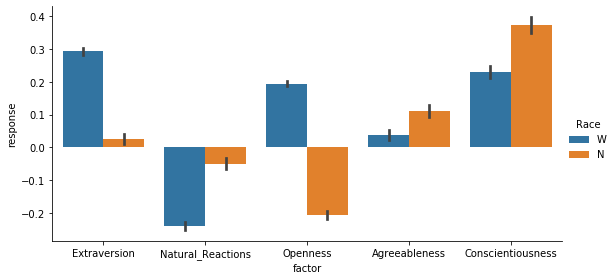

In [63]:
import seaborn as sns

g4 = sns.catplot(x='factor', y = 'response', hue  = 'Race', data=dataa, kind='bar', height=4, aspect=2)

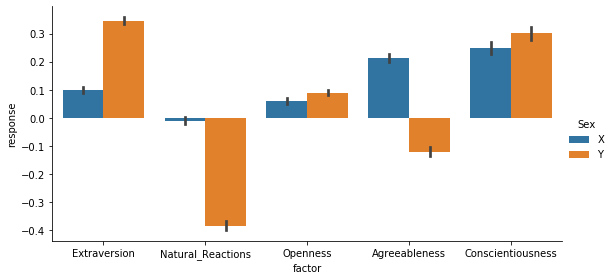

In [64]:
g4 = sns.catplot(x='factor', y = 'response', hue  = 'Sex', data=dataa, kind='bar', height=4, aspect=2)

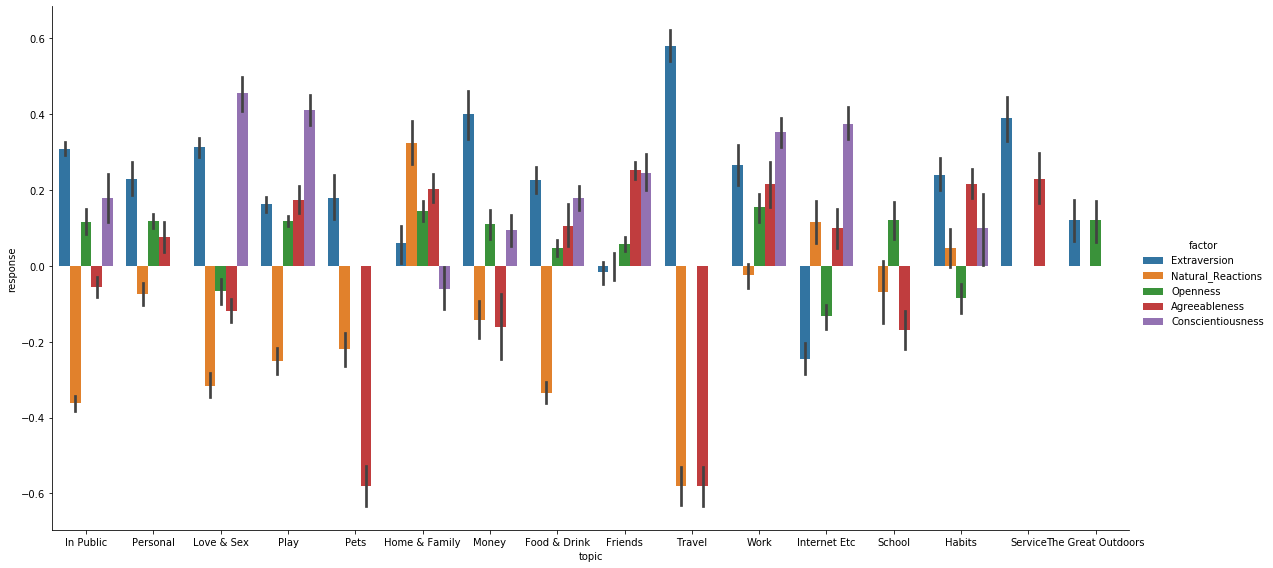

In [65]:
g4 = sns.catplot(x='topic', y = 'response', hue  = 'factor', data=dataa, kind='bar', height=8, aspect=2)

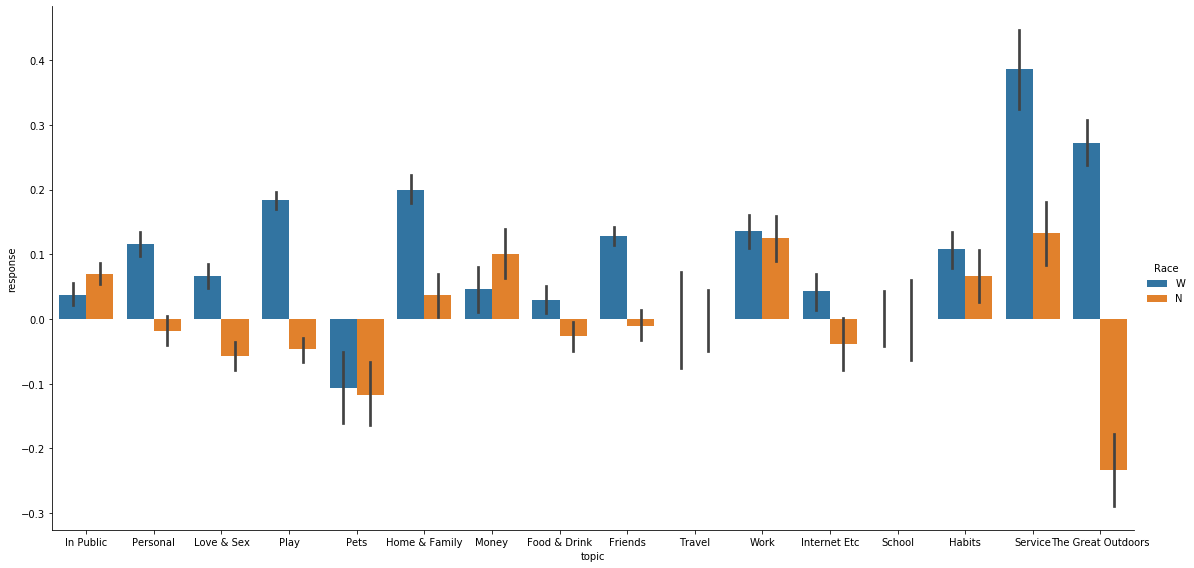

In [66]:
g4 = sns.catplot(x='topic', y = 'response', hue  = 'Race', data=dataa, kind='bar', height=8, aspect=2)

In [67]:
dataa.groupby(['type','factor','facet']).agg([np.mean])

response
                                                              mean
type         factor            facet                              
Age          Agreeableness     Sincerity                 -0.160000
             Extraversion      Assertiveness              0.160000
             Natural_Reactions Self-Consciousness        -0.100000
             Openness          Willingness to Experiment  0.100000
Ethical      Agreeableness     Sincerity                 -0.290000
             Conscientiousness Sense of Responsibility    0.180000
             Extraversion      Assertiveness              0.023333
Funny        Agreeableness     Compliance                 0.380000
                               Modesty                    0.480000
                               Sincerity                 -0.580000
             Extraversion      Assertiveness             -0.016923
                               Excitement-Seeking         0.580000
             Natural_Reactions Anxiety                   -0.580000
                               Self-Consciousness        -0.028000
Gendered     Natural_Reactions Self-Consciousness        -0.100000
             Openness          Willingness to Experiment  0.100000
Gross        Agreeableness     Compliance                 0.480000
                               Modesty                    0.730000
                               Sympathy                  -0.150000
             Extraversion      Assertiveness              0.150000
             Natural_Reactions Self-Consciousness         0.563333
Parental     Agreeableness     Altruism                   0.540000
                               Compliance                 0.270000
                               Sympathy                   0.120000
             Extraversion      Assertiveness              0.000000
             Natural_Reactions Anxiety                   -0.080000
             Openness          Imagination                0.120000
                               Willingness to Experiment  0.080000
Relationship Agreeableness     Compliance                -0.570000
                               Modesty                   -0.580000
                               Sincerity                  0.088000
                               Sympathy                  -0.470000
                               Trust in others            0.242500
             Conscientiousness Achievement Striving       0.590000
                               Self-Discipline            0.575000
                               Sense of Responsibility    0.080000
             Extraversion      Activity Level             0.120000
                               Assertiveness              0.418125
                               Excitement-Seeking         0.172000
                               Warmth                     0.410000
             Natural_Reactions Anxiety                   -0.528000
                               Moodiness                 -0.590000
                               Self-Consciousness        -0.230000
                               Sensitivity to Stress     -0.220000
             Openness          Artistic Interests         0.120000
                               Intellectual Curiosity    -0.167500
                               Tolerance for Diversity    0.410000
                               Willingness to Experiment -0.280000
School       Agreeableness     Altruism                   0.540000
             Extraversion      Assertiveness              0.540000
Substances   Agreeableness     Compliance                -0.080000
                               Modesty                   -0.570000
                               Sincerity                  0.032857
             Conscientiousness Orderliness               -0.080000
                               Self-Discipline            0.214000
             Extraversion      Activity Level             0.120000
                               Assertiveness              0.010000
             Natural_Reactions Express

In [68]:
dataa.groupby(['facet','type','Sex','Race']).agg([np.mean])

response
                                                     mean
facet                     type         Sex Race          
Achievement Striving      Relationship X   N     0.500000
                                           W     0.210526
                                       Y   N     0.928571
                                           W     0.937500
                          Work         X   N     0.541667
...                                                   ...
Willingness to Experiment Substances   Y   W     0.500000
                          Transport    X   N     0.437500
                                           W     0.052632
                                       Y   N     0.285714
                                           W     0.156250

[316 rows x 1 columns]

<Figure size 432x288 with 0 Axes>

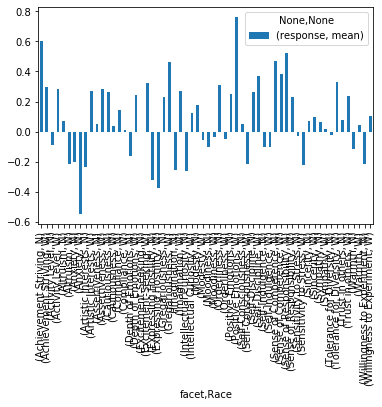

In [69]:
plt.clf()
dataa.groupby(['facet','Race']).agg([np.mean]).plot(kind='bar')
plt.show()

In [70]:
dataa.type.unique()

array([nan, 'Relationship', 'Funny', 'Gross', 'Transport', 'Gendered',
       'Parental', 'Substances', 'Trust', 'Work', 'School', 'Ethical',
       'Age'], dtype=object)

In [71]:
dataa.topic.unique()

array(['In Public', 'Personal', 'Love & Sex', 'Play', 'Pets',
       'Home & Family', 'Money', 'Food & Drink', 'Friends', 'Travel',
       'Work', 'Internet Etc', 'School', 'Habits', 'Service',
       'The Great Outdoors'], dtype=object)

In [72]:
dataa.facet.unique()

array(['Positive Emotions', 'Self-Consciousness', 'Gregariousness',
       'Willingness to Experiment', 'Activity Level',
       'Excitement-Seeking', 'Assertiveness', 'Intellectual Curiosity',
       'Compliance', 'Artistic Interests', 'Tolerance for Diversity',
       'Imagination', 'Depth of Emotions', 'Cautiousness',
       'Sense of Responsibility', 'Moodiness', 'Achievement Striving',
       'Altruism', 'Anxiety', 'Expressing Hostility',
       'Sensitivity to Stress', 'Orderliness', 'Warmth', 'Sympathy',
       'Trust in others', 'Self-Discipline', 'Sense of Competence',
       'Modesty', 'Sincerity', 'Self-Indulgence'], dtype=object)